# Writeup

1. How you prepared the data for modeling  

I downloaded `income.csv` from the official website following the assignment writeup and manually removed the comments. For extra credit, I also downloaded `education.csv` (US > By County > high school degree and above) and `poverty.csv` (US > By Counter > people below poverty). I did the rest of my data cleaning in the code that follows: I removed NA entries from both data files and inner-joined the two data files on FIPS. I visualized the histograms of income and incidence level distribution and found that both are highly right-skewed. Therefore, when modeling, I tried both the raw data and the power-transformed data (transformation suggested by Box-Cox). 


2. What features you used and how they were computed.  

I used one single predictor, `income`, to predict `incidence`. As described above in data preparation, I experimented both with the raw data and the power-transformed non-skewed data.


For extra credit, I also used `eudcation` and `poverty`. 

3. The model that you built to model the relationship, if any.

Using a single feature `income`, I built polynomial regression models varying from degree 1 (same as a linear regression) to 10.

For extra credit, I built a linear regression model using `income, education, poverty` as features to predict `incidence`.

4. How you evaluated the model.

I computed the Mean Squared Errors as well as the $R^2$ score. The differences in MSE and $R^2$ between models of different degrees aren't very large, so it might be sufficient to use the simplest linear regression model. I also visualized the model on the scatter plot of `income` vs. `incidence`.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [75]:
from sklearn.preprocessing import PolynomialFeatures, power_transform, MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [3]:
sns.set_theme()
plt.style.use('ggplot')

In [4]:
def plot_poly(model, x, y):
    x_seq = np.linspace(x.min(), x.max(), 300)[:, np.newaxis]
    plt.figure(figsize=(14, 14))
    plt.scatter(x, y, s=7)
    plt.plot(x_seq, model.predict(x_seq), color='black') 
    plt.show()

# Data Cleaning

In [5]:
df_incidence = pd.read_csv('incidence.tsv', delimiter='\t')

In [6]:
df_income = pd.read_csv('income.csv')

In [7]:
df_incidence = df_incidence.iloc[:, [0, 1, 3]]
df_incidence.columns = ['county', 'FIPS', 'incidence']

In [8]:
df_incidence.incidence = pd.to_numeric(df_incidence.incidence, errors='coerce')

In [9]:
df_incidence[df_incidence.incidence.isnull()]

,county,FIPS,incidence
2646,"Adams County, Idaho(7)",16003,NaN
2647,"Adams County, Iowa(7)",19003,NaN
2648,"Adams County, North Dakota(6)",38001,NaN
2649,"Aleutians East Borough, Alaska(6)",2013,NaN
2650,"Aleutians West Census Area, Alaska(6)",2016,NaN
...,...,...,...
2944,"Wibaux County, Montana(6)",30109,NaN
2945,"Winkler County, Texas(6)",48495,NaN
2946,"Worth County, Missouri(6)",29227,NaN
2947,"Yakutat City and Borough, Alaska(6)",2282,NaN


In [10]:
df_incidence.dropna(inplace=True)

In [11]:
df_incidence.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2646 entries, 0 to 2645
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   county     2646 non-null   object 
 1   FIPS       2646 non-null   int64  
 2   incidence  2646 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 82.7+ KB


In [12]:
df_incidence.incidence.describe()

count    2646.000000
mean       42.861867
std         9.744582
min        12.400000
25%        36.600000
50%        41.500000
75%        47.800000
max       138.600000
Name: incidence, dtype: float64

In [13]:
df_incidence.head()

,county,FIPS,incidence
0,"US (SEER+NPCR)(1,8)",0,38.4
1,"Yukon-Koyukuk Census Area, Alaska(6,8)",2290,138.6
2,"Union County, Florida(6,8)",12125,121.7
3,"Kingsbury County, South Dakota(6,8)",46077,114.2
4,"Wade Hampton Census Area, Alaska(6)",2270,102.1


In [14]:
df_income.columns = ['state', 'FIPS', 'income', 'rank']

In [15]:
df_income.income = pd.to_numeric(df_income.income, errors='coerce')

In [16]:
df_income[df_income.income.isnull()] # remove

,state,FIPS,income,rank
3141,"Rio Arriba County, New Mexico",35039,NaN,NaN


In [17]:
df_income.dropna(inplace=True)

In [18]:
df_income.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3140 entries, 1 to 3140
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   state   3140 non-null   object 
 1   FIPS    3140 non-null   int64  
 2   income  3140 non-null   float64
 3   rank    3140 non-null   object 
dtypes: float64(1), int64(1), object(2)
memory usage: 122.7+ KB


In [19]:
df_income.income.describe()

count      3140.000000
mean      64044.386624
std       15876.305519
min       21816.000000
25%       53544.500000
50%       62116.000000
75%       71340.250000
max      178542.000000
Name: income, dtype: float64

# Join on FIPS

In [20]:
df = df_income.set_index('FIPS').join(df_incidence.set_index('FIPS'),
                                     how='inner')

In [21]:
df.head()

,state,income,rank,county,incidence
FIPS,,,,,
28063,"Jefferson County, Mississippi",21816.0,3140 of 3140,"Jefferson County, Mississippi(6,8)",73.7
46121,"Todd County, South Dakota",22889.0,3139 of 3140,"Todd County, South Dakota(6,8)",52.7
72001,Puerto Rico,24391.0,3138 of 3140,"Puerto Rico(6,10)",41.2
28051,"Holmes County, Mississippi",26374.0,3137 of 3140,"Holmes County, Mississippi(6,8)",74.7
13061,"Clay County, Georgia",27500.0,3136 of 3140,"Clay County, Georgia(7)",65.7


In [22]:
df.isnull().any().sum() # no null since we did inner join

0

# Visualize the distribution of income and incidence respectively

<AxesSubplot:xlabel='income', ylabel='Count'>

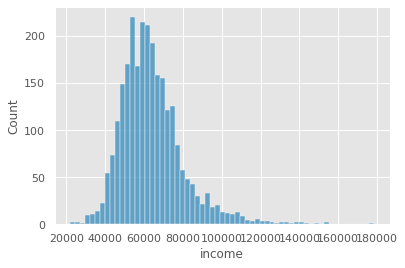

In [23]:
sns.histplot(df.income)

<AxesSubplot:xlabel='incidence', ylabel='Count'>

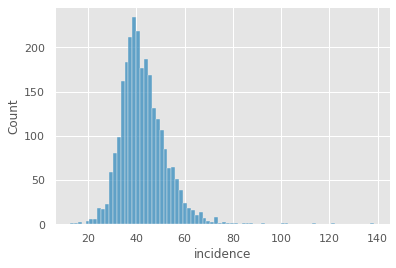

In [24]:
sns.histplot(df.incidence)

The data looks highly skewed so we might consider tranforming both the predictor and the response.

# Visualize incidence against income
I hypothesize that cancer incidence rate will be negatively correlated with income.

<AxesSubplot:xlabel='income', ylabel='incidence'>

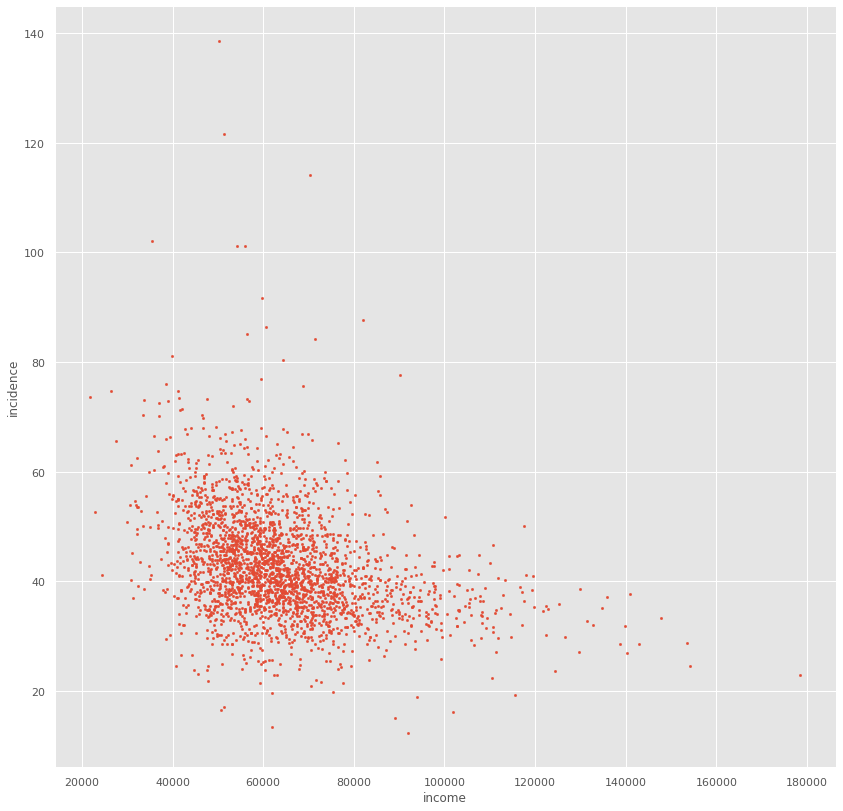

In [25]:
plt.figure(figsize=(14, 14))
sns.scatterplot(data=df, x='income', y='incidence', 
                edgecolor=None, s=7) # markersize

In [26]:
# correlation
df.income.corr(df.incidence)

-0.34961106831031824

From the scatter plot and the correlation statistics, it appears that income is negatively correlated with cancer incidence rate, which aligns with my hypothesis.

# Fit Polynomial Models without Transforming the Data

In [27]:
x = df.income.to_numpy()[:, np.newaxis]
y = df.incidence

In [28]:
models = []
mse_list, rsquared_list = [], []
for degree in range(1, 11): # fit up to degree 10
    model = make_pipeline(PolynomialFeatures(degree),
                          LinearRegression())
    model.fit(x, y)
    y_pred = model.predict(x)
    
    mse_list.append(mean_squared_error(y, y_pred))
    rsquared_list.append(r2_score(y, y_pred))
    models.append(model)

In [29]:
results = pd.DataFrame({
    'degree': range(1, 11),
    'mean_squared_error': mse_list,
    'r_squared': rsquared_list
})

In [30]:
results

,degree,mean_squared_error,r_squared
0,1,83.374385,0.122228
1,2,82.758108,0.128716
2,3,82.566037,0.130738
3,4,82.724699,0.129068
4,5,83.116125,0.124947
5,6,83.830157,0.117429
6,7,84.872170,0.106459
7,8,86.135015,0.093164
8,9,87.456759,0.079248
9,10,88.700524,0.066154


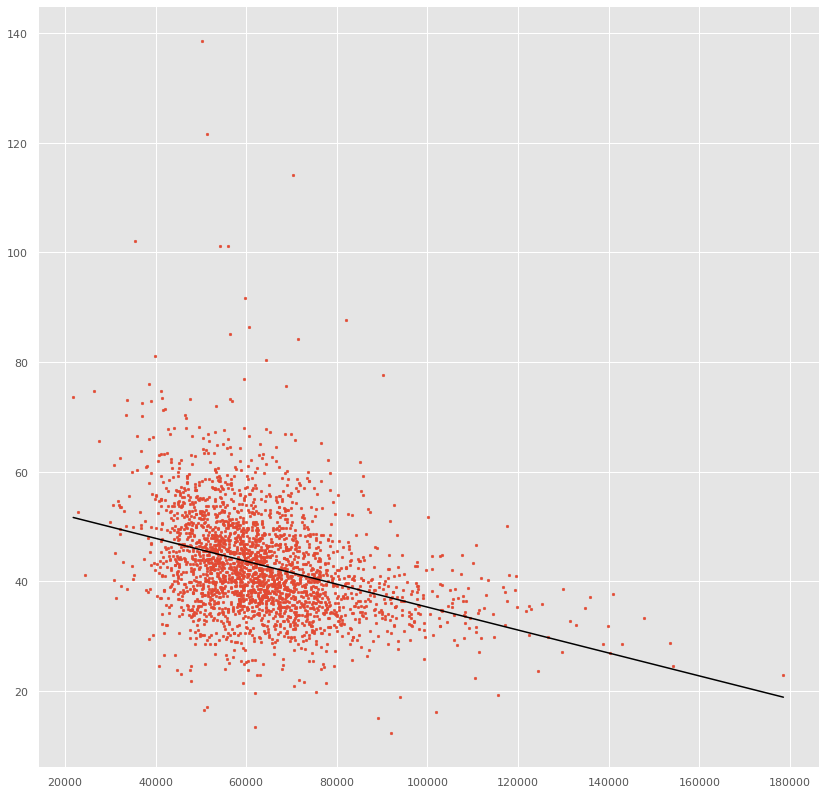

In [31]:
plot_poly(models[0], x, y)

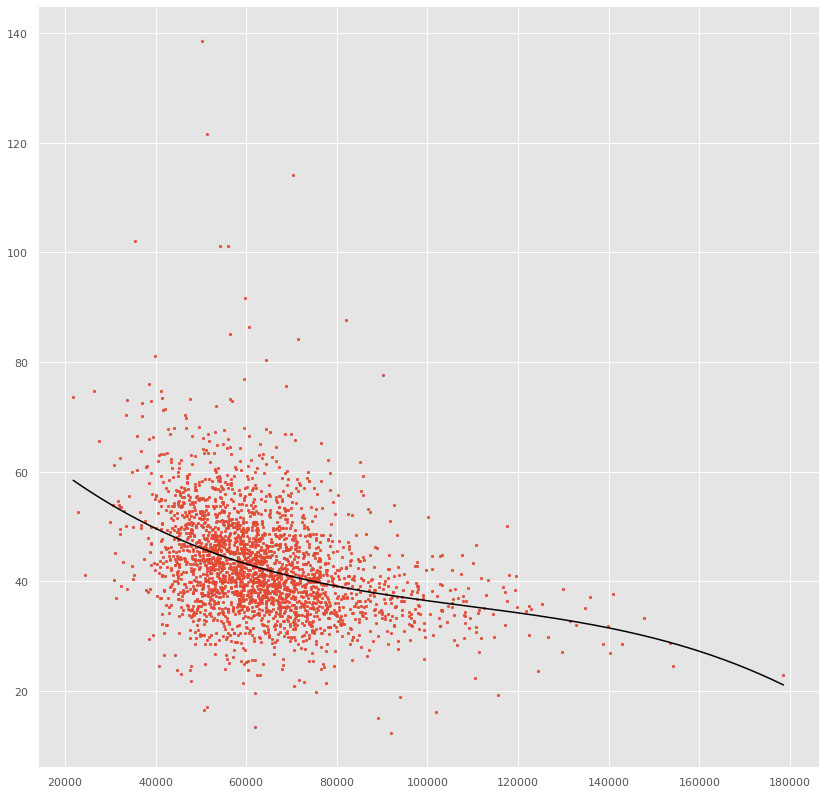

In [32]:
plot_poly(models[2], x, y) # degree 2

Judgin from the $R^2$ scores, none of the models is very good. We do observe a consistent negative slope of the fitted model, which agrees with the negative correlation between income and incidence. This indicates that a higher income is correlated with a lower incidence rate. Moreover, the slope of the 3rd degree polynomial decreases at a decreasing rate (it even flattens out farther away from the center of the datapoints). This may mean that at higher incomes, a significant increase in income results in a less significant decrease in incidence rate.

Next we try applying powe transforms to eliminate the skewness in the data.

# Power Transformation

In [33]:
x_pow = power_transform(x, method='box-cox')
y_pow = power_transform(y.to_numpy()[:, np.newaxis], 
                        method='box-cox').squeeze()

In [34]:
np.corrcoef(x.squeeze(), y), np.corrcoef(x_pow.squeeze(), y_pow)

(array([[ 1.        , -0.34961107],
        [-0.34961107,  1.        ]]),
 array([[ 1.        , -0.36949874],
        [-0.36949874,  1.        ]]))

Through data transformation, we have slightly increased the correlation. The histograms below also look more normal.

Text(0.5, 1.0, 'income power-transformed')

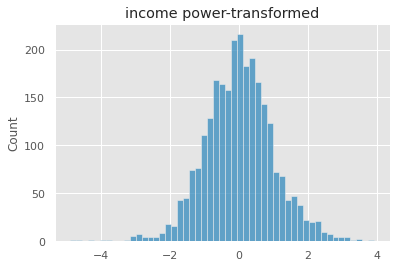

In [35]:
ax = sns.histplot(x_pow.squeeze())
ax.set_title('income power-transformed')

Text(0.5, 1.0, 'incidence power transformed')

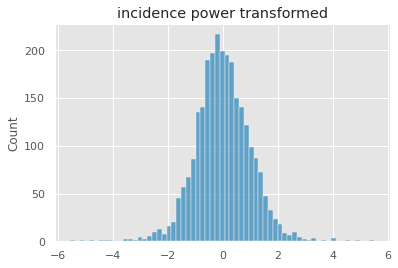

In [36]:
ax = sns.histplot(y_pow)
ax.set_title('incidence power transformed')

<AxesSubplot:>

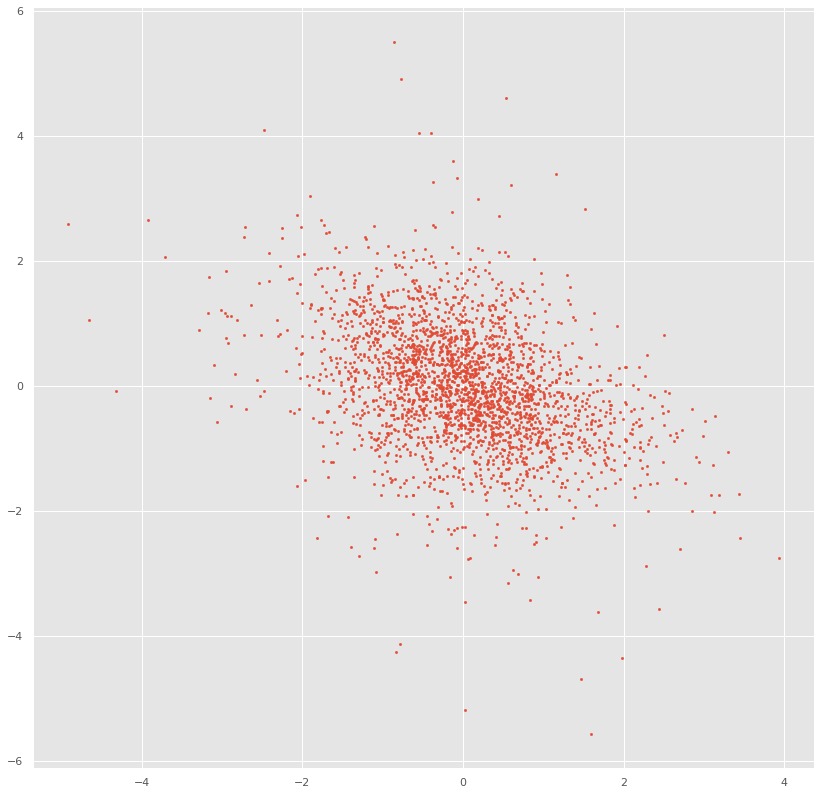

In [37]:
plt.figure(figsize=(14, 14))
sns.scatterplot(x=x_pow.squeeze(), y=y_pow, edgecolor=None, s=7) # markersize

In [38]:
models_pow = []
mse_list, rsquared_list = [], []
for degree in range(1, 11): # fit up to degree 10
    model = make_pipeline(PolynomialFeatures(degree),
                          LinearRegression())
    model.fit(x_pow, y_pow)
    y_pred = model.predict(x_pow)
    
    mse_list.append(mean_squared_error(y, y_pred))
    rsquared_list.append(r2_score(y, y_pred))
    models_pow.append(model)

In [39]:
results_pow = pd.DataFrame({
    'degree': range(1, 11),
    'mean_squared_error': mse_list,
    'r_squared': rsquared_list
})

In [40]:
results_pow

,degree,mean_squared_error,r_squared
0,1,1929.856913,-19.317686
1,2,1929.860260,-19.317721
2,3,1929.855537,-19.317671
3,4,1929.854680,-19.317662
4,5,1929.854650,-19.317662
5,6,1929.853862,-19.317654
6,7,1929.832034,-19.317424
7,8,1929.824361,-19.317343
8,9,1929.823616,-19.317335
9,10,1929.823156,-19.317330


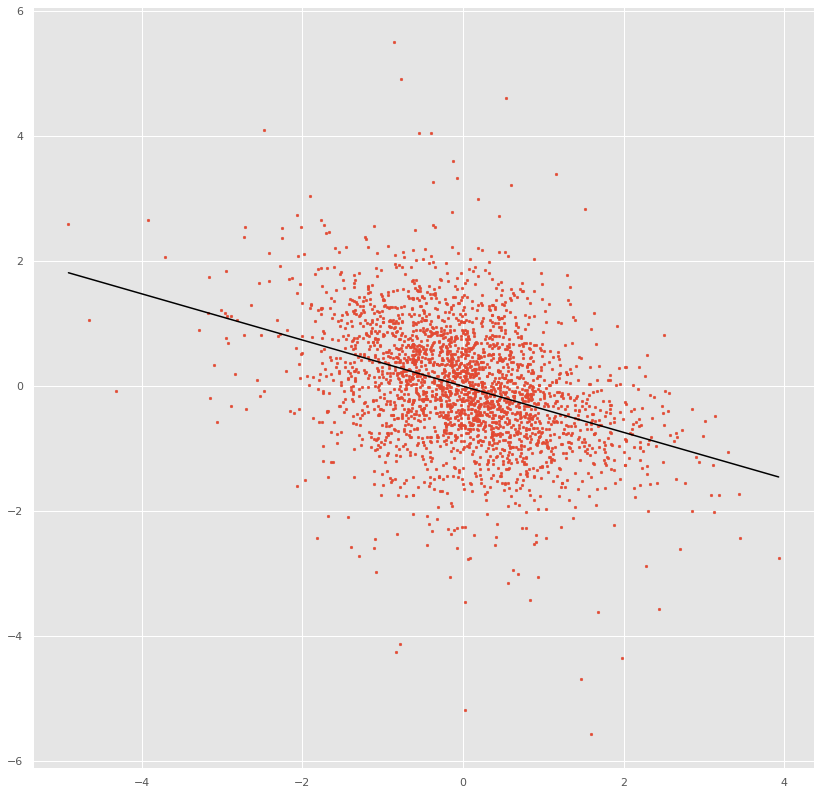

In [41]:
plot_poly(models_pow[0], x_pow, y_pow)

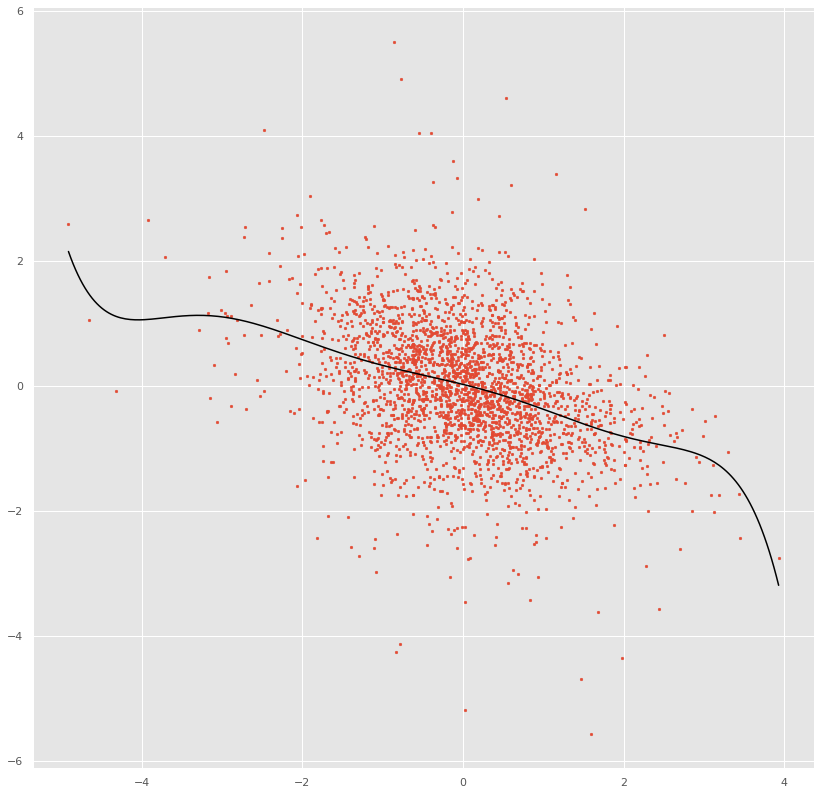

In [42]:
plot_poly(models_pow[6], x_pow, y_pow)

# Extra Credit
For education, I used the percent of people with at least a high school education. For poverty, I used the percent of people below poverty. My hypothesis is that `incidence` is inversely correlated with `income` and `education`, but positively correlated with `poverty`. One more thing to note is that there might be issues with multicolinearity between `income` and `poverty`, as a county with a higher median family income is likely to have fewer people below poverty.

I chose `income, education, poverty` as these social-economic factors are easy to interpret.

In [46]:
education_df = pd.read_csv('education.csv')
poverty_df = pd.read_csv('poverty.csv')

In [49]:
# data cleaning
education_df = education_df.iloc[:, :3]
education_df.columns = ['state', 'FIPS', 'percent_high_school'] 

In [50]:
education_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3142 entries, 0 to 3141
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   state                3142 non-null   object 
 1   FIPS                 3142 non-null   int64  
 2   percent_high_school  3142 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 73.8+ KB


In [54]:
poverty_df = poverty_df.iloc[:, :3]
poverty_df.columns = ['state', 'FIPS', 'percent_poverty']
poverty_df.percent_poverty = pd.to_numeric(poverty_df.percent_poverty,
                                          errors='coerce')
poverty_df.dropna(inplace=True)

In [55]:
poverty_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3141 entries, 0 to 3140
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   state            3141 non-null   object 
 1   FIPS             3141 non-null   int64  
 2   percent_poverty  3141 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 98.2+ KB


In [56]:
education_df.head()

,state,FIPS,percent_high_school
0,United States,0,87.7
1,"Petroleum County, Montana",30069,98.8
2,"Falls Church City, Virginia",51610,98.8
3,"Rich County, Utah",49033,98.6
4,"Denali, Alaska",2068,98.4


In [58]:
poverty_df.head()

,state,FIPS,percent_poverty
0,United States,0,14.1
1,"Todd County, South Dakota",46121,55.1
2,"Jefferson County, Mississippi",28063,49.7
3,"Shannon County, South Dakota",46113,49.3
4,"East Carroll Parish, Louisiana",22035,48.6


In [63]:
df_all = df.join(education_df.set_index('FIPS')\
                 .drop(columns='state'), how='inner')\
.join(poverty_df.set_index('FIPS').drop(columns='state'), how='inner')

In [64]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2644 entries, 28063 to 51610
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   state                2644 non-null   object 
 1   income               2644 non-null   float64
 2   rank                 2644 non-null   object 
 3   county               2644 non-null   object 
 4   incidence            2644 non-null   float64
 5   percent_high_school  2644 non-null   float64
 6   percent_poverty      2644 non-null   float64
dtypes: float64(4), object(3)
memory usage: 165.2+ KB


In [65]:
df_all.head()

,state,income,rank,county,incidence,percent_high_school,percent_poverty
FIPS,,,,,,,
28063,"Jefferson County, Mississippi",21816.0,3140 of 3140,"Jefferson County, Mississippi(6,8)",73.7,74.8,49.7
46121,"Todd County, South Dakota",22889.0,3139 of 3140,"Todd County, South Dakota(6,8)",52.7,77.9,55.1
72001,Puerto Rico,24391.0,3138 of 3140,"Puerto Rico(6,10)",41.2,75.5,44.5
28051,"Holmes County, Mississippi",26374.0,3137 of 3140,"Holmes County, Mississippi(6,8)",74.7,75.1,43.6
13061,"Clay County, Georgia",27500.0,3136 of 3140,"Clay County, Georgia(7)",65.7,79.8,41.1


In [67]:
df_all = df_all[['incidence', 'income', 'percent_high_school', 
                 'percent_poverty']]

In [71]:
df_all.corr()

,incidence,income,percent_high_school,percent_poverty
incidence,1.000000,-0.349611,-0.276225,0.309932
income,-0.349611,1.000000,0.646632,-0.759910
percent_high_school,-0.276225,0.646632,1.000000,-0.672754
percent_poverty,0.309932,-0.759910,-0.672754,1.000000


As I hypothesized, `incidence` is negatively correlated with `income` and `education`, and is positively correlated with `poverty`. `income` is also positively highly correlated with `education` and negatively highly correlated with `poverty`.

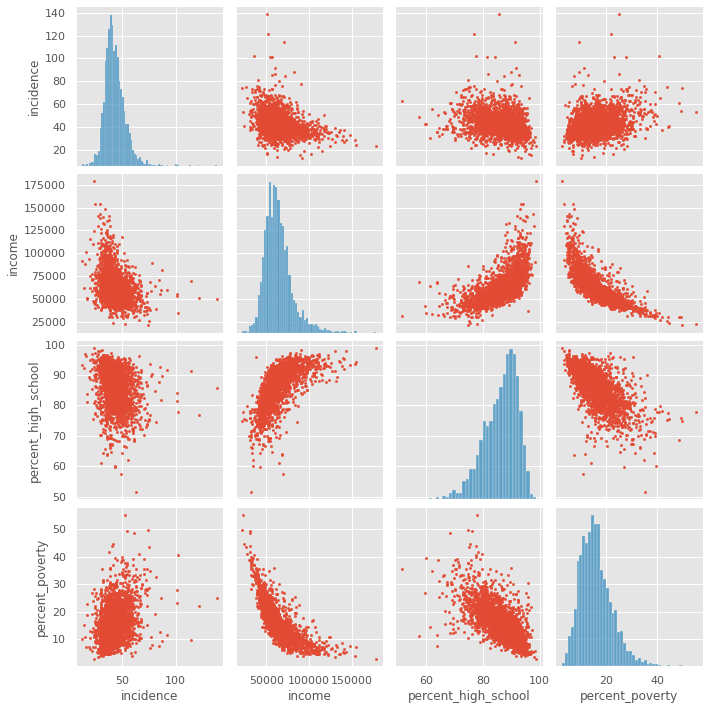

In [70]:
sns.pairplot(df_all, plot_kws={'edgecolor': None, 's': 7})

# Fit a linear model

In [74]:
x = df_all.iloc[:, 1:].to_numpy()
y = df_all.iloc[:, 0].to_numpy()
lm = LinearRegression().fit(x, y)
y_pred = lm.predict(x)
mean_squared_error(y, y_pred), r2_score(y , y_pred)

(82.75108835111568, 0.12879001197753603)

The three variables could still only explan less than 13% of the variation in the response variable `incidence`. There isn't much improvement from using `income` alone. That's reasonable as `income` has the highest correlation with `incidence` and the other two predictors are correlated with `income`, hencing adding less new information.


As our data doesn't look Guassian, we try normalizing it using `MinMaxScaler`. The results, however, didn't change.

In [83]:
scaler = MinMaxScaler() 
x = scaler.fit_transform(x)
lm = LinearRegression().fit(x, y)
y_pred = lm.predict(x)
mean_squared_error(y, y_pred), r2_score(y , y_pred)

(82.75108835111568, 0.12879001197753603)